In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
from tensorflow.keras.datasets import mnist
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, UpSampling2D, BatchNormalization, MaxPool2D, DenseFeatures
from tensorflow.keras.models import Sequential
import time
import sys
import cv2
from skimage.transform import resize
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import mnist
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()



In [23]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [0]:
x_train = train_images/255
x_test = test_images/255

In [0]:
class image_compression:

    def __init__(self):
      self.model = None
    
    def fit(self, X, Y, model_name):
      pass

    def load_model(self, model_name):
      pass

    def compress(self, X):
      pass
    
    def decompress(self, X):
      pass

    def evaluate(self, X):
      pass

    def save_model(name):
      pass
    

In [0]:
class Resize_compression(image_compression):

  def __init__(self, percent, noise = 0, *args, **kwargs):
    assert(percent > 0 and percent <= 1)
    assert(noise >= 0)
    self.percent = percent
    self.noise = noise
    self.compression = 1 / percent
    super(Resize_compression, self).__init__(*args, **kwargs)
  
  def fit(self, X, Y, model_name):
      pass

  def load_model(self, model_name):
      pass

  def compress(self, X):
      # def single_comp(x):
      #   print("Yo", x.shape)
      #   shape = (int(self.percent * x.shape[0]), int(int(self.percent * x.shape[1])))
      #   return resize(x, shape)
      
      # comp = np.vectorize(single_comp)
      
      if (noise != 0):
        X += np.random.normal(0, self.noise, X.shape)
      r_shape = (int(round(self.percent * X.shape[1])), int(round(self.percent * X.shape[2])))
      # print("Compress:", r_shape)
      y = np.zeros((X.shape[0], r_shape[0], r_shape[1], X.shape[3]))
      for i in range(0, X.shape[0]):
        # print(X[i].shape)
        y[i] = resize(X[i], r_shape)
      return y
    
  def decompress(self, X):
      inv = 1.0 / self.percent
      
      # def single_decomp(self, x):
      #   shape = (int(inv * x.shape[0]), int(inv * x.shape[1]))
      #   return resize(x, shape)
      # decomp = np.vectorize(single_decomp)
      # return decomp(X)

      r_shape = (int(round(inv * X.shape[1])), int(round(inv * X.shape[2])))
      # print("Decompress:", r_shape)
      y = np.zeros((X.shape[0], r_shape[0], r_shape[1], X.shape[3]))
      for i in range(0, X.shape[0]):
        # print(X[i].shape)
        y[i] = resize(X[i], r_shape)
      return y

  def evaluate(self, X):
      return self.decompress(self.compress(X))

  def save_model(name):
      pass

In [0]:
class PCA_compression(image_compression):

  def __init__(self, var_ratio, noise = 0, *args, **kwargs):
    assert(var_ratio > 0 and var_ratio <= 1)
    self.var_ratio = var_ratio
    self.noise = noise
    self.compression_factor = None
    super(PCA_compression, self).__init__(*args, **kwargs)
  
  def fit(self, X, model_name = None):
    pca = PCA(self.var_ratio)
    if (noise != 0):
      X += np.random.normal(0, self.noise, X.shape)
    print("Training...")
    start = time.time()
    pca.fit(X.reshape(X.shape[0], -1))
    print("Elapsed Time:", time.time() - start)
    self.model = pca
    self.compression = pca.n_features_ / pca.n_components_
  
  def load_model(*args, **kwargs):
    pass

  def compress(self, X):
    return self.model.transform(X)

  def decompress(self, X):
    return self.model.inverse_transform(X)

  def evaluate(self, X):
    return self.decompress(self.compress(X.reshape(X.shape[0], -1))).reshape(X.shape)

  def save_model(model):
    pass

In [0]:
class ConvNetCompression8810(image_compression):
  def __init__(self, X, Y, noise = 0, in_shape=(32,32,3), model_name=None):
    assert(noise >= 0)
    self.model = Sequential()
    self.model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=in_shape))
    self.model.add(BatchNormalization())     # 32x32x32
    self.model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))      # 16x16x32 =2
    self.model.add(Conv2D(10, kernel_size=3, strides=1, padding='same', activation='relu'))      # 16x16x32
    self.model.add(Conv2D(10, kernel_size=3, strides=2, padding='same', activation='relu'))      # 8x8x32
    self.model.add(BatchNormalization())     # 8x8x32
    self.model.add(UpSampling2D())
    self.model.add(BatchNormalization())     # 16x16x32
    self.model.add(UpSampling2D())
    self.model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 32x32x32
    self.model.add(BatchNormalization())
    self.model.add(Conv2D(3,  kernel_size=1, strides=1, padding='same', activation='sigmoid'))   # 32x32x3

    self.model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')
    self.model.summary()
    self.noise = noise
    self.compression = 4.8
    if model_name is not None:
      try:
        f = open(model_name)      
        f.close()
        self.load_model(model_name)
      except IOError:
        self.fit(X, Y, model_name)
    else:
      self.fit(X, Y, model_name)

  
  def fit(self, X, Y, model_name):
    num_epochs = 5
    # NOISE = 0.2     # Set to 0 for a regular (non-denoising...) autoencoder
    for i in range(num_epochs):
      if (self.noise != 0):
        noisy_X = X + np.random.normal(0, self.noise, X.shape)
        self.model.fit(noisy_X, Y, epochs=1, batch_size=128)
      else:
        self.model.fit(X, Y, epochs=1, batch_size=128)

    self.model.save(model_name)

  def load_model(self, model_name):
    self.model.load_weights(model_name)

  def compress(self, X):
    pass

  def decompress(self, X):
    pass

  def evaluate(self, X):
    return self.model.predict(X)

In [0]:
class ConvNetCompression8816(image_compression):
  def __init__(self, X, Y, noise = 0, in_shape=(32,32,3), model_name=None):
    assert(noise >= 0)
    self.model = Sequential()
    self.model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=in_shape))
    self.model.add(BatchNormalization())     # 32x32x32
    self.model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))      # 16x16x32 =2
    self.model.add(Conv2D(16, kernel_size=3, strides=1, padding='same', activation='relu'))      # 16x16x32
    self.model.add(Conv2D(16, kernel_size=3, strides=2, padding='same', activation='relu'))      # 8x8x32
    self.model.add(BatchNormalization())     # 8x8x32
    self.model.add(UpSampling2D())
    self.model.add(BatchNormalization())     # 16x16x32
    self.model.add(UpSampling2D())
    self.model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 32x32x32
    self.model.add(BatchNormalization())
    self.model.add(Conv2D(3,  kernel_size=1, strides=1, padding='same', activation='sigmoid'))   # 32x32x3

    self.model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')
    self.model.summary()
    self.noise = noise
    self.compression = 3
    if model_name is not None:
      try:
        f = open(model_name)      
        f.close()
        self.load_model(model_name)
      except IOError:
        self.fit(X, Y, model_name)
    else:
      self.fit(X, Y, model_name)

  
  def fit(self, X, Y, model_name):
    num_epochs = 5
    # noise = 0.2     # Set to 0 for a regular (non-denoising...) autoencoder
    for i in range(num_epochs):
      if (self.noise != 0):
        noisy_X = X + np.random.normal(0, self.noise, X.shape)
        self.model.fit(noisy_X, X, epochs=1, batch_size=128)
      else:
        self.model.fit(X, X, epochs=1, batch_size=128)
    
    self.model.save(model_name)

  def load_model(self, model_name):
    self.model.load_weights(model_name)

  def compress(self, X):
    pass

  def decompress(self, X):
    pass

  def evaluate(self, X):
    return self.model.predict(X)

In [0]:
# class CBNN(image_compression):
#   def __init__(self, X, Y, noise = 0, compression_factor = 0.5, in_shape=(32,32,3), model_name=None):
#     assert(noise >= 0)
#     assert(0 < compression_factor and compression_factor <= 1)
#     self.noise = noise
#     self.compression_factor = compression_factor
#     self.bottle_neck = int(compression_factor * X.shape[1] * X.shape[2])

#     self.model = Sequential()
#     self.model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=in_shape))
#     self.model.add(BatchNormalization())     # 32x32x32
#     self.model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))      # 16x16x32 =2
#     self.model.add(Dense(self.bottle_neck, activation = 'relu'))
#     self.model.add(BatchNormalization())     # 8x8x32
#     self.model.add(UpSampling2D())
#     self.model.add(BatchNormalization())     # 16x16x32
#     self.model.add(UpSampling2D())
#     self.model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 32x32x32
#     self.model.add(BatchNormalization())
#     self.model.add(Conv2D(3,  kernel_size=1, strides=1, padding='same', activation='sigmoid'))   # 32x32x3


#     self.model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')
#     self.model.summary()
#     if model_name is not None:
#       try:
#         f = open(model_name)      
#         f.close()
#         self.load_model(model_name)
#       except IOError:
#         self.fit(X, Y, model_name)
#     else:
#       self.fit(X, Y, model_name)

  
#   def fit(self, X, Y, model_name):
#     num_epochs = 5
#     # noise = 0.2     # Set to 0 for a regular (non-denoising...) autoencoder
#     for i in range(num_epochs):
#       if (self.noise != 0):
#         noisy_X = X + np.random.normal(0, self.noise, X.shape)
#         self.model.fit(noisy_X, X, epochs=1, batch_size=128)
#       else:
#         self.model.fit(X, X, epochs=1, batch_size=128)
    
#     self.model.save(model_name)

#   def load_model(self, model_name):
#     self.model.load_weights(model_name)

#   def compress(self, X):
#     pass

#   def decompress(self, X):
#     pass

#   def evaluate(self, X):
#     return self.model.predict(X)

In [31]:
# if()
c_model = models.Sequential()

c_model = models.Sequential()
c_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
c_model.add(layers.MaxPooling2D((2, 2)))
c_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
c_model.add(layers.MaxPooling2D((2, 2)))
c_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
c_model.add(layers.Flatten())
c_model.add(layers.Dense(64, activation='relu'))
c_model.add(layers.Dense(10, activation='softmax'))
c_model.summary()


c_model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
history = c_model.fit(x_train, train_labels, epochs=10, 
                      validation_data=(x_test, test_labels))
c_model.save("YOO.h5")
c_model.load_weights("YOO.h5")

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [32]:
noise = 0
test = ConvNetCompression8810(x_train, x_train, noise = noise, model_name = "8810_noise_" + str(noise) + ".h5")

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 10)        2890      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 8, 8, 10)          910       
_________________________________________________________________
batch_normalization_17 (Batc (None, 8, 8, 10)          40        
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 16, 16, 10)       

In [33]:
noise = 0.2
test_8810_noise = ConvNetCompression8810(x_train, x_train, noise = noise,  model_name = "8810_noise_" + str(noise) + ".h5")

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 16, 16, 10)        2890      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 8, 8, 10)          910       
_________________________________________________________________
batch_normalization_21 (Batc (None, 8, 8, 10)          40        
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 16, 16, 10)       

In [34]:
noise = 0
test2 = ConvNetCompression8816(x_train, x_train, noise = noise, model_name = "8816_noise_" + str(noise) + ".h5")

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_24 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 16, 16, 16)        4624      
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 8, 8, 16)          2320      
_________________________________________________________________
batch_normalization_25 (Batc (None, 8, 8, 16)          64        
_________________________________________________________________
up_sampling2d_12 (UpSampling (None, 16, 16, 16)      

In [35]:
noise = 0.2
test_8816_noise = ConvNetCompression8816(x_train, x_train, noise = noise, model_name = "8816_noise_" + str(noise) + ".h5")

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 16, 16, 16)        4624      
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 8, 8, 16)          2320      
_________________________________________________________________
batch_normalization_29 (Batc (None, 8, 8, 16)          64        
_________________________________________________________________
up_sampling2d_14 (UpSampling (None, 16, 16, 16)      

In [36]:
test3 = PCA_compression(0.98)
test4 = PCA_compression(0.98)
sample_noise = 0.2
z = x_train + np.random.normal(0, sample_noise, x_train.shape)
# z = x_train
test3.fit(z)
test4.fit(x_train)

Training...
Elapsed Time: 120.59754848480225
Training...
Elapsed Time: 116.74145078659058


In [0]:

# accs_o = []
# accs_8810 = []
# accs_8816 = []
# accs_pca = []
# noises = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
# for NOISE in noises:
#   print("Using Noise of:", NOISE)
#   noise = np.random.normal(0, NOISE, x_test.shape)
#   sample = x_test + noise

#   results = test.evaluate(sample)
#   results2 = test2.evaluate(sample)  # 2
#   results3 = test3.evaluate(sample)

#   test_loss_o, test_acc_o = c_model.evaluate(sample,  test_labels, verbose=2)
  
#   test_loss, test_acc_8810 = c_model.evaluate(results,  test_labels, verbose=2)
#   test_loss_pca, test_acc_8816 = c_model.evaluate(results2,  test_labels, verbose=2)
#   test_loss_pca, test_acc_pca = c_model.evaluate(results3,  test_labels, verbose=2)

  
#   accs_o.append(test_acc_o)

#   accs_8810.append(test_acc_8810)
#   accs_8816.append(test_acc_8816)
#   accs_pca.append(test_acc_pca)
#   print()

In [0]:

# plt.plot(noises,accs_o, label = "Original")
# plt.plot(noises,accs_8810, label = "8810")
# plt.plot(noises, accs_8816, label = "8816")
# plt.plot(noises, accs_pca, label = "PCA_0.98")
# plt.legend()
# plt.show()

In [0]:
# plt.plot(noises,accs_o, label = "Original")
# plt.plot(noises,accs_8810, label = "8810")
# plt.plot(noises, accs_8816, label = "8816")
# plt.plot(noises, accs_pca, label = "PCA_0.98")
# plt.legend()
# plt.show()

In [40]:
def compare_models(models, noises):
  accurracies = {}

  for k, v in models.items():
    accurracies[k] = [] 
  
  accurracies["Original"] = []

  for NOISE in noises:
    print("Using Noise of:", NOISE)
    noise = np.random.normal(0, NOISE, x_test.shape)
    sample = x_test + noise

    for k, model in models.items():
      result = model.evaluate(sample)
      accurracies[k].append(c_model.evaluate(result, test_labels, verbose=2)[1])

    accurracies["Original"].append(c_model.evaluate(sample, test_labels, verbose=2)[1])


  return accurracies

noises = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
model_names = ["8810", "8816", "PCA_0.98_N=0.2", "PCA_0.98_N=0", "Resize_compression_0.8", "8810_N=0.2", "8816_N=0.2"]
models_list = [test, test2, test3, test4, Resize_compression(0.8), test_8810_noise, test_8816_noise]
m = dict(zip(model_names, models_list))
# print(m)
accuracies = compare_models(m, noises)

Using Noise of: 0.0
10000/10000 - 1s - loss: 1.0806 - acc: 0.6247
10000/10000 - 1s - loss: 1.0580 - acc: 0.6338
10000/10000 - 1s - loss: 0.8917 - acc: 0.6984
10000/10000 - 1s - loss: 0.9291 - acc: 0.6836
10000/10000 - 1s - loss: 0.9848 - acc: 0.6564
10000/10000 - 1s - loss: 1.3532 - acc: 0.5363
10000/10000 - 1s - loss: 1.3282 - acc: 0.5486
10000/10000 - 1s - loss: 0.8923 - acc: 0.6973
Using Noise of: 0.05
10000/10000 - 1s - loss: 1.0977 - acc: 0.6151
10000/10000 - 1s - loss: 1.0777 - acc: 0.6259
10000/10000 - 1s - loss: 1.0215 - acc: 0.6564
10000/10000 - 1s - loss: 0.9639 - acc: 0.6706
10000/10000 - 1s - loss: 0.9936 - acc: 0.6515
10000/10000 - 1s - loss: 1.3489 - acc: 0.5371
10000/10000 - 1s - loss: 1.3183 - acc: 0.5496
10000/10000 - 1s - loss: 1.0306 - acc: 0.6559
Using Noise of: 0.1
10000/10000 - 1s - loss: 1.1825 - acc: 0.5858
10000/10000 - 1s - loss: 1.1639 - acc: 0.5961
10000/10000 - 1s - loss: 1.5198 - acc: 0.5337
10000/10000 - 1s - loss: 1.1096 - acc: 0.6276
10000/10000 - 1s - 

8810 [0.6247, 0.6151, 0.5858, 0.5393, 0.4785, 0.422, 0.3668]
8816 [0.6338, 0.6259, 0.5961, 0.5466, 0.4707, 0.4103, 0.3411]
PCA_0.98_N=0.2 [0.6984, 0.6564, 0.5337, 0.3938, 0.3025, 0.2479, 0.2058]
PCA_0.98_N=0 [0.6836, 0.6706, 0.6276, 0.56, 0.4877, 0.4241, 0.3595]
Resize_compression_0.8 [0.6564, 0.6515, 0.6274, 0.5678, 0.4859, 0.4095, 0.3328]
8810_N=0.2 [0.5363, 0.5371, 0.5352, 0.5399, 0.5363, 0.5302, 0.5071]
8816_N=0.2 [0.5486, 0.5496, 0.5478, 0.5569, 0.5539, 0.5457, 0.5196]
Original [0.6973, 0.6559, 0.5278, 0.3889, 0.2958, 0.2395, 0.2018]


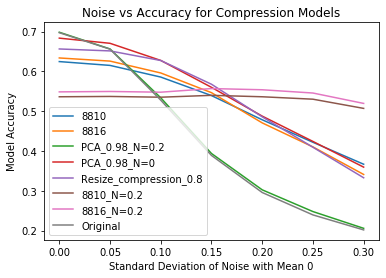

In [41]:
def plot_models(accs, noises):
  for k, v in accs.items():
    print(k, v)
    plt.plot(noises, v, label = k)
    
  plt.xlabel("Standard Deviation of Noise with Mean 0")
  plt.ylabel("Model Accuracy")
  plt.title("Noise vs Accuracy for Compression Models")
  plt.legend()
  plt.savefig("noise_vs_model_acurracy.png")
  plt.show()

plot_models(accuracies, noises)

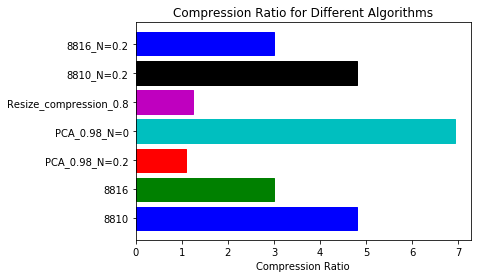

In [56]:
# for k, v in m.items():
#   print(v.compression)


def graph_compressions(models):
  names = []
  comps = []
  for k, v in m.items():
    comps.append(v.compression)
    names.append(k)

  
  y_pos = np.arange(len(names))
  

  barlist = plt.barh(y_pos, comps, align='center', alpha=1)
  color_list = ['b', 'g', 'r', 'c', 'm', 'k']
  for i in range(0, len(barlist)):
    barlist[i].set_color(color_list[i % len(color_list)])

  plt.yticks(y_pos, names)
  plt.xlabel('Compression Ratio')
  plt.title('Compression Ratio for Different Algorithms')
  plt.show()

graph_compressions(m)

In [61]:
def time_to_evaluate(models, images):
  num_images = images.shape[0]
  times = {}
  for k, v in models.items():
    print("Timing " + k + "...")
    start = time.time()
    v.evaluate(images)
    end = time.time()
    times[k] = 1000 * (end - start) / num_images


  return times


times = time_to_evaluate(m, x_test)
for k, v in times.items():
  print(k, ":", v)





Timing 8810...
Timing 8816...
Timing PCA_0.98_N=0.2...
Timing PCA_0.98_N=0...
Timing Resize_compression_0.8...
Timing 8810_N=0.2...
Timing 8816_N=0.2...
8810 : 0.08133769035339355
8816 : 0.07902534008026123
PCA_0.98_N=0.2 : 0.8880181312561035
PCA_0.98_N=0 : 0.17361345291137695
Resize_compression_0.8 : 2.302498292922974
8810_N=0.2 : 0.08335337638854981
8816_N=0.2 : 0.08355581760406494


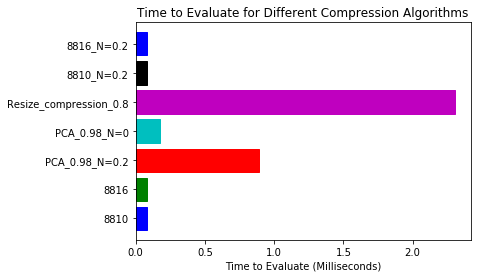

In [62]:
def graph_times(times):
 
  y_pos = np.arange(len(times))
  

  barlist = plt.barh(y_pos, times.values(), align='center', alpha=1)
  color_list = ['b', 'g', 'r', 'c', 'm', 'k']
  for i in range(0, len(barlist)):
    barlist[i].set_color(color_list[i % len(color_list)])

  plt.yticks(y_pos, times.keys())
  plt.xlabel('Time to Evaluate (Milliseconds)')
  plt.title('Time to Evaluate for Different Compression Algorithms')
  plt.show()


graph_times(times)



In [65]:
print((times["PCA_0.98_N=0"]/ times["PCA_0.98_N=0.2"]) ** - 1)
print(m["PCA_0.98_N=0"].compression/ m["PCA_0.98_N=0.2"].compression)

5.114915442119586
6.382882882882883
